# The Video Segmentater using SAM2

The Google Colab link: https://colab.research.google.com/drive/1q-_LLIBZ-WW64VRzJ9fSVYDBOvADvWkW?usp=sharing

## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Fri May  9 06:49:05 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   42C    P8             11W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [2]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


## Setup

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Install SAM2 and dependencies

In [4]:
!git clone https://github.com/facebookresearch/segment-anything-2.git
%cd {HOME}/segment-anything-2
!pip install -e . -q
!python setup.py build_ext --inplace

Cloning into 'segment-anything-2'...
remote: Enumerating objects: 1070, done.
remote: Total 1070 (delta 0), reused 0 (delta 0), pack-reused 1070 (from 1)
Receiving objects: 100% (1070/1070), 128.11 MiB | 15.82 MiB/s, done.
Resolving deltas: 100% (381/381), done.
/content/segment-anything-2
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 13.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 130.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━

In [5]:
!pip install -q supervision[assets] jupyter_bbox_widget

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.7/220.7 kB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 842.5/842.5 kB 59.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 84.5 MB/s eta 0:00:00


### Download SAM2 checkpoints

**NOTE:** SAM2 is available in 4 different model sizes ranging from the lightweight "sam2_hiera_tiny" (38.9M parameters) to the more powerful "sam2_hiera_large" (224.4M parameters).

In [6]:
!mkdir -p {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_tiny.pt -P {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_small.pt -P {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_base_plus.pt -P {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt -P {HOME}/checkpoints

## Imports

In [7]:
import cv2
import torch
import base64

import numpy as np
import supervision as sv

from pathlib import Path
from supervision.assets import download_assets, VideoAssets
from sam2.build_sam import build_sam2_video_predictor

IS_COLAB = True

if IS_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()

from jupyter_bbox_widget import BBoxWidget

**NOTE:** This code enables mixed-precision computing for faster deep learning. It uses bfloat16 for most calculations and, on newer NVIDIA GPUs, leverages TensorFloat-32 (TF32) for certain operations to further boost performance.

In [8]:
torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

if torch.cuda.get_device_properties(0).major >= 8:
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

## Load model

In [9]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
CHECKPOINT = f"{HOME}/checkpoints/sam2_hiera_large.pt"
CONFIG = "sam2_hiera_l.yaml"

sam2_model = build_sam2_video_predictor(CONFIG, CHECKPOINT)

## Preprocess video

### (Optional) Images -> Video

In [ ]:
# @title Generate video
import cv2
import os
import glob
import numpy as np
from google.colab import files
from tqdm.autonotebook import tqdm


image_dir = "/content/drive/MyDrive/data/PhD/2024-09-10_08-12-30.810_measurement_calibration_part1/sync_rgb" # @param {"type":"string"}
img_ext = "jpeg" # @param {"type":"string"}
fps = 10 # @param {"type":"number"}
down_frame_rate = 1 # @param {"type":"number"}
output_path = "/content/drive/Othercomputers/My MacBook Air/calibration_v1.2/2024-05-26_15-28-32.795_measurement/sync_rgb.mp4" # @param {"type":"string"}

# Get image files
image_files = sorted(glob.glob(os.path.join(image_dir, f'*.{img_ext}')))

# Read first image to get dimensions
frame = cv2.imread(image_files[0])
height, width, _ = frame.shape

# Create video writer object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(
    output_path, fourcc,
    fps / down_frame_rate,
    (width, height)
)

# Process each image
for i in tqdm(range(0, len(image_files), down_frame_rate)):
    img = cv2.imread(image_files[i])
    out.write(img)

# Release video writer
out.release()

# download the video
# files.download(output_path)

  0%|          | 0/692 [00:00<?, ?it/s]

### Download video and split it into frames

**NOTE:** SAM2 assumee that the video is stored as a list of JPEG frames with filenames like `<frame_index>.jpg`. Let's start by downloading a sample video, splitting it into frames, and saving them to disk. Feel free to replace `SOURCE_VIDEO` with the path to your video file.

In [10]:
# @title Define the input video
SOURCE_VIDEO = "/content/drive/MyDrive/data/PhD/2024-09-10_08-12-30.810_measurement_calibration_part1/video_10fps.mp4" # @param {type:"string"}
# SOURCE_VIDEO = download_assets(VideoAssets.BASKETBALL)
sv.VideoInfo.from_video_path(SOURCE_VIDEO)

VideoInfo(width=2048, height=1088, fps=10, total_frames=70)

**NOTE:** To reduce VRAM requirements, we are introducing three additional parameters: `SCALE_FACTOR` to decrease the frame resolution, and `START_IDX` and `END_IDX` to extract only the relevant segments from the video.

In [11]:
# @title Define the target frames
SCALE_FACTOR = 1  # @param {type:"number"}
START_IDX = 0  # @param {type:"integer"}
END_IDX = -1   # @param {type:"integer"}
OUT_DIR = '/content/drive/MyDrive/data/PhD/2024-09-10_08-12-30.810_measurement_calibration_part1/output_box'    # @param {type:"string"}
OUT_DIR = Path(OUT_DIR)

os.makedirs(OUT_DIR, exist_ok=True)
END_IDX = None if END_IDX == -1 else END_IDX


SOURCE_FRAMES = Path(HOME) / Path(SOURCE_VIDEO).stem
SOURCE_FRAMES.mkdir(parents=True, exist_ok=True)

frames_generator = sv.get_video_frames_generator(SOURCE_VIDEO, start=START_IDX, end=END_IDX)
images_sink = sv.ImageSink(
    target_dir_path=SOURCE_FRAMES.as_posix(),
    overwrite=True,
    image_name_pattern="{:05d}.jpeg"
)

with images_sink:
    for frame in frames_generator:
        frame = sv.scale_image(frame, SCALE_FACTOR)
        images_sink.save_image(frame)

TARGET_VIDEO = '/content/drive/MyDrive/data/PhD/2024-09-10_08-12-30.810_measurement_calibration_part1/video_10fps_output.mp4'   # @param {type:"string"}
TARGET_VIDEO = Path(TARGET_VIDEO)
SOURCE_FRAME_PATHS = sorted(sv.list_files_with_extensions(SOURCE_FRAMES.as_posix(), extensions=["jpeg"]))

### Initialize the inference state

**NOTE:** SAM 2 requires stateful inference for interactive video segmentation, so we need to initialize an inference state on this video. During initialization, it loads all the JPEG frames in `video_path` and stores their pixels in `inference_state` (as shown in the progress bar below).

In [12]:
inference_state = sam2_model.init_state(
    video_path=SOURCE_FRAMES.as_posix(),
    async_loading_frames=True
)

frame loading (JPEG):   9%|▊         | 6/70 [00:00<00:03, 17.60it/s]

**NOTE:** If you have run any previous tracking using this inference_state, please reset it first via reset_state. (The cell below is just for illustration; it's not needed to call reset_state here as this inference_state is just freshly initialized above.)

In [13]:
sam2_model.reset_state(inference_state)

### Prompting with points

frame loading (JPEG): 100%|██████████| 70/70 [00:07<00:00,  9.84it/s]


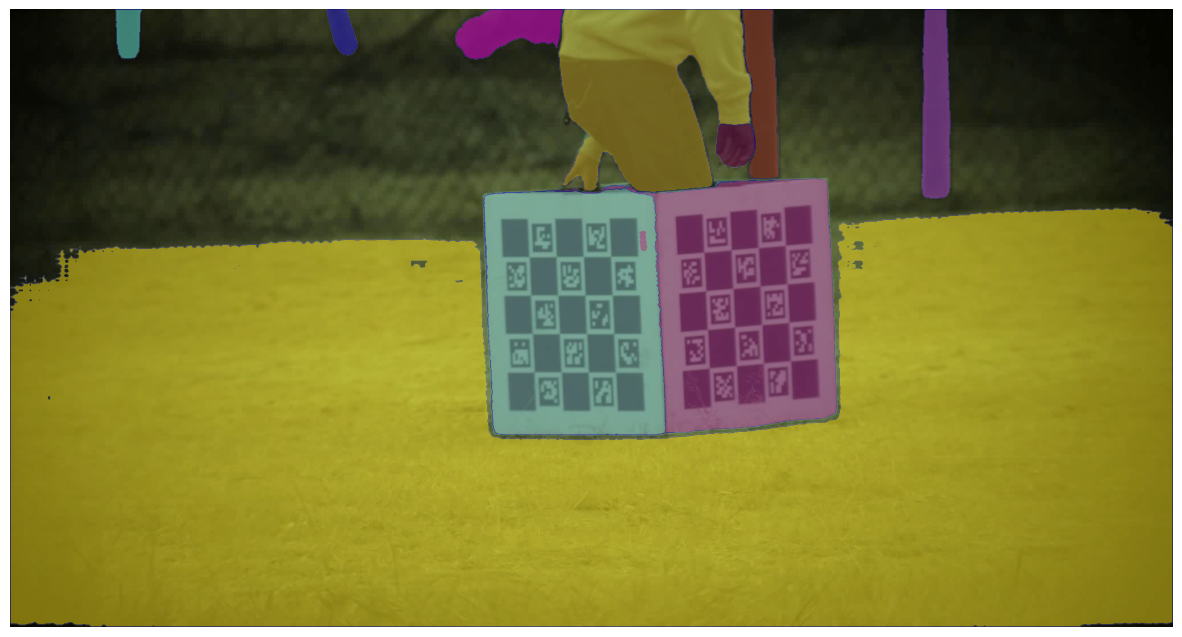

In [14]:
# @title Automatic mask generation
from PIL import Image
import matplotlib.pyplot as plt
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator


def show_anns(anns, borders=True):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.5]])
        img[m] = color_mask
        if borders:
            import cv2
            contours, _ = cv2.findContours(m.astype(np.uint8),cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
            # Try to smooth contours
            contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
            cv2.drawContours(img, contours, -1, (0,0,1,0.4), thickness=1)

    ax.imshow(img)


FRAME_IDX = 0  # @param {type:"integer"}
FRAME_PATH = Path(SOURCE_FRAMES) / f"{FRAME_IDX:05d}.jpeg"

image = Image.open(FRAME_PATH)
image = np.array(image.convert("RGB"))

stability_score_thresh = 0.9  # @param {type:"number"}
mask_generator = SAM2AutomaticMaskGenerator(
    sam2_model,
    stability_score_thresh=stability_score_thresh
)
masks = mask_generator.generate(image)
plt.figure(figsize=(15, 15))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show()

**NOTE:** SAM2 allows tracking multiple objects at once. Update the `OBJECTS` list if you want to change the list of tracked objects.

In [15]:
OBJECTS = ['calib_box']
sam2_model.reset_state(inference_state)

**NOTE:** Let's choose the index of the reference frame that we will use to annotate the objects we are looking for.

In [16]:
# @title Annotation for the initial frame
FRAME_IDX = 0  # @param {type:"integer"}
FRAME_PATH = Path(SOURCE_FRAMES) / f"{FRAME_IDX:05d}.jpeg"


def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

widget = BBoxWidget(classes=OBJECTS)
widget.image = encode_image(FRAME_PATH)
widget

BBoxWidget(classes=['calib_box'], colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#…

In [17]:
widget.bboxes

[{'x': 915, 'y': 417, 'width': 0, 'height': 0, 'label': 'calib_box'},
 {'x': 1037, 'y': 601, 'width': 4, 'height': 0, 'label': 'calib_box'},
 {'x': 1250, 'y': 646, 'width': 0, 'height': 0, 'label': 'calib_box'},
 {'x': 1392, 'y': 423, 'width': 0, 'height': 0, 'label': 'calib_box'},
 {'x': 1252, 'y': 420, 'width': 0, 'height': 0, 'label': 'calib_box'},
 {'x': 1116, 'y': 375, 'width': 0, 'height': 0, 'label': 'calib_box'},
 {'x': 1320, 'y': 542, 'width': 0, 'height': 2, 'label': 'calib_box'},
 {'x': 1387, 'y': 632, 'width': 0, 'height': 0, 'label': 'calib_box'},
 {'x': 909, 'y': 671, 'width': 3, 'height': 0, 'label': 'calib_box'}]

**NOTE:** The widget we are using stores annotations in a format that is inconsistent with SAM2's requirements. We parse them and then pass them to SAM2 via the `add_new_points` method. Each of the objects we track must be passed via a separate `add_new_points` call. It is important to specify `frame_idx` each time - the index of the frame to which the annotations relate, and `obj_id` - the ID of the object to which the annotations relate.

In [18]:
for object_id, label in enumerate(OBJECTS, start=1):
    boxes = [box for box in widget.bboxes if box['label'] == label]

    if len(boxes) == 0:
        continue

    points = np.array([
        [
            box['x'],
            box['y']
        ] for box in boxes
    ], dtype=np.float32)
    labels = np.ones(len(points))

    _, object_ids, mask_logits = sam2_model.add_new_points(
        inference_state=inference_state,
        frame_idx=FRAME_IDX,
        obj_id=object_id,
        points=points,
        labels=labels,
    )

### Video inference

**NOTE:** To apply our point prompts to all video frames, we use the `propagate_in_video` generator. Each call returns `frame_idx` - the index of the current frame, `object_ids` - IDs of objects detected in the frame, and `mask_logits` - corresponding `object_ids` logit values, which we can convert to masks using thresholding.

In [19]:
import pickle

video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO)
video_info.width = int(video_info.width * SCALE_FACTOR)
video_info.height = int(video_info.height * SCALE_FACTOR)

COLORS = ['#FF1493', '#00BFFF', '#FF6347', '#FFD700']
mask_annotator = sv.MaskAnnotator(
    color=sv.ColorPalette.from_hex(COLORS),
    color_lookup=sv.ColorLookup.CLASS)

frame_sample = []
metadata_result = {
    'id2label': {k: v for k, v in enumerate(OBJECTS)},
    'label2id': {v: k for k, v in enumerate(OBJECTS)},
    'scale_factor': SCALE_FACTOR,
    'masks': []
}

with sv.VideoSink(TARGET_VIDEO.as_posix(), video_info=video_info) as sink:
    for frame_idx, object_ids, mask_logits in sam2_model.propagate_in_video(inference_state):
        frame_path = SOURCE_FRAME_PATHS[frame_idx]
        frame = cv2.imread(frame_path)
        masks = (mask_logits > 0.0).cpu().numpy()
        masks = np.squeeze(masks).astype(bool)

        if len(masks.shape) < 3:
            masks = np.expand_dims(masks, axis=0)

        detections = sv.Detections(
            xyxy=sv.mask_to_xyxy(masks=masks),
            mask=masks,
            class_id=np.array(object_ids)
        )

        annotated_frame = mask_annotator.annotate(
            scene=frame.copy(),
            detections=detections)

        # save data
        metadata_result['masks'].append(masks.tolist())
        # save frame
        cv2.imwrite(os.path.join(OUT_DIR, f'{frame_idx:05d}.png'), annotated_frame)

        sink.write_frame(annotated_frame)
        if frame_idx % video_info.fps == 0:
            frame_sample.append(annotated_frame)

with open(os.path.join(OUT_DIR, 'metadata_result.pickle'), 'wb') as f:
    pickle.dump(metadata_result, f, protocol=pickle.HIGHEST_PROTOCOL)

# download the video
# files.download(TARGET_VIDEO.as_posix())

propagate in video: 100%|██████████| 70/70 [00:19<00:00,  3.59it/s]


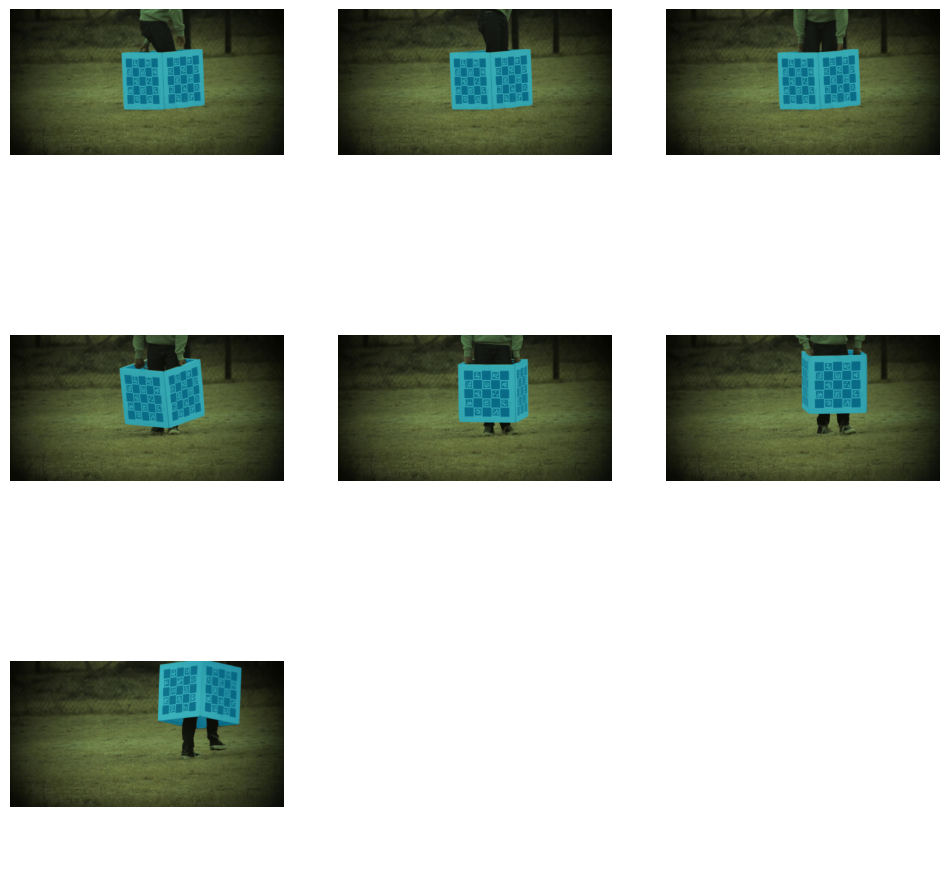

In [20]:
sv.plot_images_grid(
    images=frame_sample[:9],
    grid_size=(3, 3)
)